In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import matplotlib.pyplot as plt

import os

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from statistics import variance, mean 
#!pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


In [2]:
train_df = pd.read_csv('train.csv')
train_df.head(2)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5


## Feature Exploration

In [3]:
# mention category variables in df
category_pat = ['Soil_Type', 'Wilderness_Area', 'Cover_Type']
category_col_names = [col_name for col_name in train_df.columns if 1 in [1 for categ in category_pat if categ in col_name]]
for var in category_col_names:
    train_df[var] = train_df[var].astype('category')

In [52]:
def get_scaled_features(df, scaler=None):
    if scaler == None:
        scaler = StandardScaler()
        scaler.fit(df)
    
    return scaler.transform(df), scaler

In [10]:
soil_features = [feature for feature in category_col_names if 'Soil' in feature]
wilderness_features = [feature for feature in category_col_names if 'Wilderness' in feature]

def get_categ_features(df):
    soil_res = np.add(np.where(df[soil_features]==1)[1], 1)
    wilder_res = np.add(np.where(df[wilderness_features]==1)[1], 1)
    
    return {'Soil_Type': soil_res, 'Wilderness_Type': wilder_res}

In [6]:
target_var = 'Cover_Type'

#### Get Statistics of variables
- Within their own distribution
- With respect to target variable

In [12]:
category_features = get_categ_features(train_df)
for categ_f in category_features.keys():
    train_df.loc[:,categ_f] = category_features[categ_f]

In [16]:
category_features

{'Soil_Type': array([29, 29, 12, ...,  4,  4,  2], dtype=int64),
 'Wilderness_Type': array([1, 1, 1, ..., 3, 3, 3], dtype=int64)}

In [14]:
# check variability of columns to identify prospective features
from statistics import variance, mean 
col_stat_df = pd.DataFrame(columns=['col_name', 'mean','variance'])
for column_name in train_df.columns:
    col_stat_df.loc[len(col_stat_df)] = [column_name, np.round(mean(train_df[column_name]),2), np.round(variance(train_df[column_name]),2)]
    #print('%-40s : %f  %f'% (column_name, round(mean(train_df[column_name]),2), round(variance(train_df[column_name]),2)))

col_stat_df = col_stat_df.sort_values('variance')
col_stat_df = col_stat_df.set_index('col_name')
col_stat_df.head()

,mean,variance
col_name,,
Soil_Type7,0.0,0.0
Soil_Type27,0.0,0.0
Soil_Type26,0.0,0.0
Soil_Type25,0.0,0.0
Soil_Type37,0.0,0.0


In [15]:
col_stat_df

,mean,variance
col_name,,
Soil_Type7,0.00,0.00
Soil_Type27,0.00,0.00
Soil_Type26,0.00,0.00
Soil_Type25,0.00,0.00
Soil_Type37,0.00,0.00
Soil_Type36,0.00,0.00
Soil_Type21,0.00,0.00
Soil_Type34,0.00,0.00
Soil_Type28,0.00,0.00


In [19]:
# remove columns with low variance
selected_features = set(train_df.columns)
selected_features.remove('Id')
selected_features.remove(target_var)
selected_features = selected_features.difference(soil_features)
selected_features = selected_features.difference(wilderness_features)

In [20]:
selected_features

{'Aspect',
 'Elevation',
 'Hillshade_3pm',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Horizontal_Distance_To_Fire_Points',
 'Horizontal_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Slope',
 'Soil_Type',
 'Vertical_Distance_To_Hydrology',
 'Wilderness_Type'}

0.008014997104571377


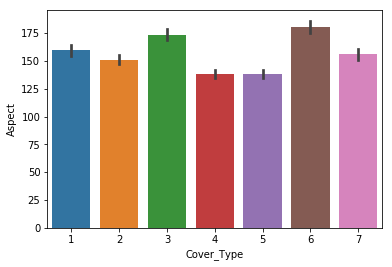

-0.05339867835933383


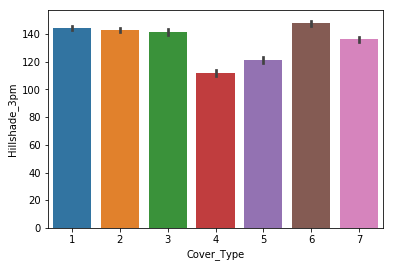

0.0160900438182509


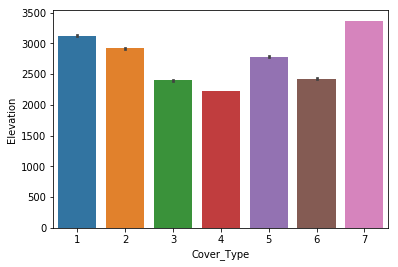

0.0877216002864924


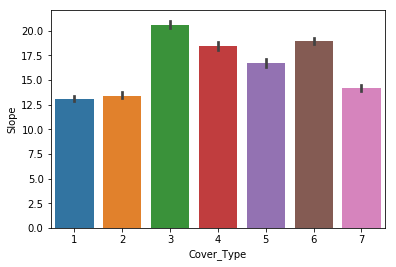

-0.1056622237807925


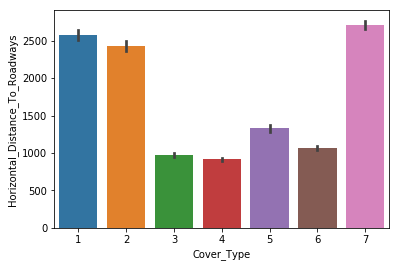

0.07564672644424436


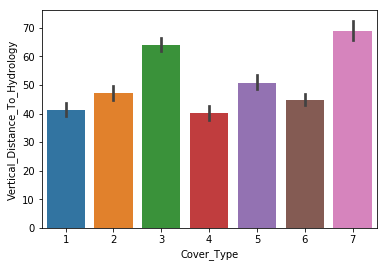

-0.01028628960460759


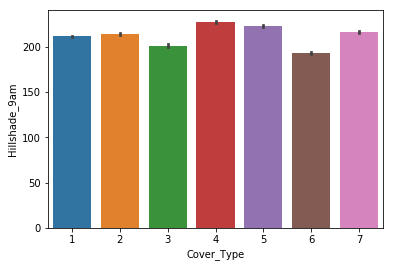

-0.01051528507550603


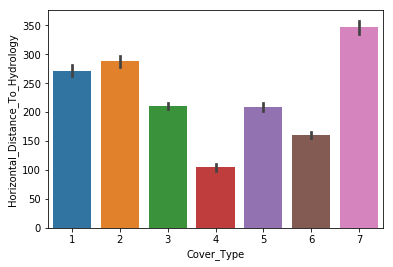

-0.09890521520398583


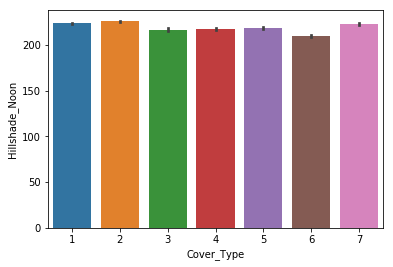

0.07620474228904846


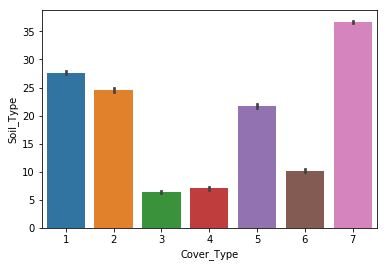

-0.08938891870312761


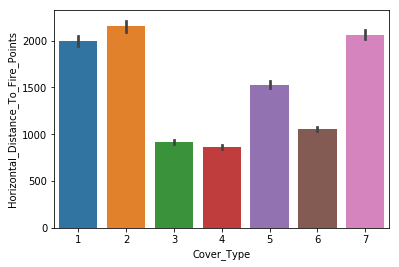

0.20388267989115352


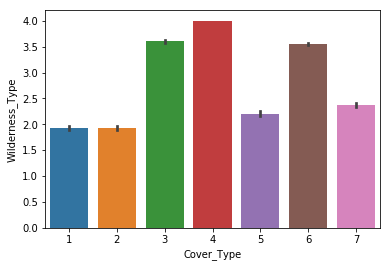

In [28]:
# Check variation of feature variables wrt target
for f in selected_features:
    #plt.scatter()
    print(np.corrcoef(train_df[target_var], train_df[f])[0][1])
    sns.barplot(train_df[target_var], train_df[f])
    plt.show()

### Evaluate Feature Importance

In [53]:
X = train_df[selected_features]
y = train_df[target_var]
scaled_X, scaler = get_scaled_features(X)

C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [36]:
rf_model = RandomForestClassifier(n_estimators=2000, n_jobs=-1, oob_score=True)
res = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
res.mean()

0.788690476190476

In [54]:
rf_model = RandomForestClassifier(n_estimators=2000, n_jobs=-1, oob_score=True)
res = cross_val_score(rf_model, scaled_X, y, cv=10, scoring='accuracy')
res.mean()

0.7893518518518519

In [33]:
res.mean()

0.790542328042328

In [44]:
# Grid search for optimized paramters
n_estimators_ops = [100, 500, 1000, 1500, 2000, 2500, 3000]
train_scores = []
oob_scores = []
cv_scores = []

for n_estimators in n_estimators_ops:
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=0, oob_score=True)
    cv_res = cross_val_score(rf, X, y, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(cv_res.mean())
    rf.fit(X, y)
    train_scores.append(rf.score(X, y))
    oob_scores.append(rf.oob_score_)

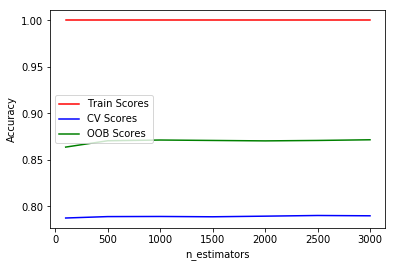

In [46]:
plt.plot(n_estimators_ops, train_scores, 'r', label = 'Train Scores')
plt.plot(n_estimators_ops, cv_scores, 'b', label='CV Scores')
plt.plot(n_estimators_ops, oob_scores, 'g', label='OOB Scores')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

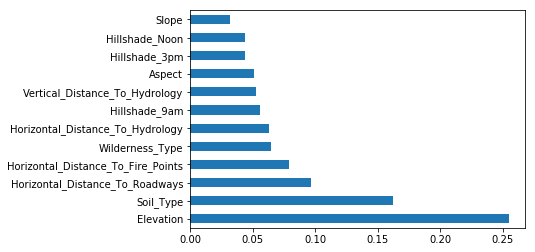

In [59]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')
plt.show()

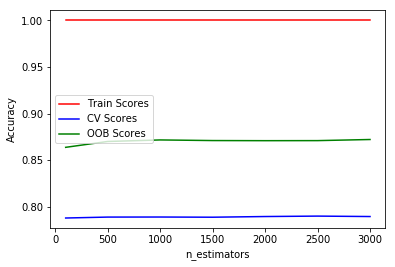

In [55]:
# Grid search for optimized paramters
n_estimators_ops = [100, 500, 1000, 1500, 2000, 2500, 3000]
train_scores = []
oob_scores = []
cv_scores = []

for n_estimators in n_estimators_ops:
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=0, oob_score=True)
    cv_res = cross_val_score(rf, scaled_X, y, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(cv_res.mean())
    rf.fit(scaled_X, y)
    train_scores.append(rf.score(scaled_X, y))
    oob_scores.append(rf.oob_score_)
    
plt.plot(n_estimators_ops, train_scores, 'r', label = 'Train Scores')
plt.plot(n_estimators_ops, cv_scores, 'b', label='CV Scores')
plt.plot(n_estimators_ops, oob_scores, 'g', label='OOB Scores')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
n_estimators_ops[np.argmax(cv_scores)], n_estimators_ops[np.argmax(oob_scores)]

(2500, 3000)

In [48]:
n_estimators_ops[np.argmax(cv_scores)], n_estimators_ops[np.argmax(oob_scores)]

(2500, 3000)

In [49]:
cv_scores

[0.7874338624338624,
 0.7889550264550265,
 0.7890873015873016,
 0.7887566137566138,
 0.7894179894179894,
 0.7901455026455027,
 0.7898148148148149]

In [50]:
oob_scores

[0.8636904761904762,
 0.8705026455026456,
 0.8712962962962963,
 0.8708333333333333,
 0.8703703703703703,
 0.8708333333333333,
 0.8715608465608465]

In [57]:
rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [ ]:
"""
Preprocessing:
    1. sqrt
    2. log
    Brings large values closer to their average: better for NN learning drastically
"""
"""
Ordinal are ordered, not necessarily by same interval.. so can't be treated as numeric
"""

###Feature Generation

# Combined distance from horizontal and vert distance to source = sqrt(hor^2 + ver^2) : Hypotenuse